In [1]:
import os
import cv2
from PIL import Image 
import numpy as np 
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt
import random

os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras
import segmentation_models as sm

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.models import Model
# high level for processing and layering
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda
# import direct backend methods for calculations
from keras import backend as K

minmaxscaler = MinMaxScaler()

Segmentation Models: using `tf.keras` framework.


#### Image Segmentation  
dataset: https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery

Building: #3C1098  
Land (unpaved area): #8429F6  
Road: #6EC1E4  
Vegetation: #FEDD3A  
Water: #E2A929  
Unlabeled: #9B9B9B  

![title](Images/Folder_structure_segm.png)

| Satellite Image             |  Mask |
|-------------------------|-------------------------|
![sat_img](Datasets/Segmentation_Tasks/Semantic%20segmentation%20dataset/Tile%201/images/image_part_009.jpg) | ![mask_img](Datasets/Segmentation_Tasks/Semantic%20segmentation%20dataset/Tile%201/masks/image_part_009.png)
![sat_img](Datasets/Segmentation_Tasks/Semantic%20segmentation%20dataset/Tile%205/images/image_part_007.jpg) | ![mask_img](Datasets/Segmentation_Tasks/Semantic%20segmentation%20dataset/Tile%205/masks/image_part_007.png)

In [2]:
dataset_root = 'Datasets/Segmentation_Tasks/Semantic segmentation dataset'

In [3]:
image = cv2.imread(f'{dataset_root}/Tile 2/images/image_part_001.jpg',1)

In [4]:
image.shape

(544, 509, 3)

In [5]:
# patchfy can split images into small overlappable patches by given patch cell size, and merge patches into original image.
# This will split the image into small images of shape [3,3]
image_patch_size = 256
image_patches = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
len(image_patches)

2

Break large images into smaller patches and normalize them, to ensure the dataset is ready for patch-based processing and semantic segmentation.  

For image patches:  
- Min-max normalization is applied using minmaxscaler.
- Each normalized patch is stored in image_dataset.
  
For mask patches:  
- Patches are directly stored in mask_dataset.

In [6]:
# Store processed image patches in arrays
image_dataset = []
mask_dataset = []

for image_type in ['images' , 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
      
  elif image_type == 'masks':
     image_extension = 'png'
      
  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
        
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
        # Dimensions are cropped to the nearest multiple of image_patch_size for both width and height  
        size_x = (image.shape[1]//image_patch_size) * image_patch_size
        size_y = (image.shape[0]//image_patch_size) * image_patch_size
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        image = np.array(image)
        # Divide into smaller patches of size
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
          
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            # Scale between 0 and 1
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              image_dataset.append(individual_patched_image)
                
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)

In [7]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

(-0.5, 255.5, 255.5, -0.5)

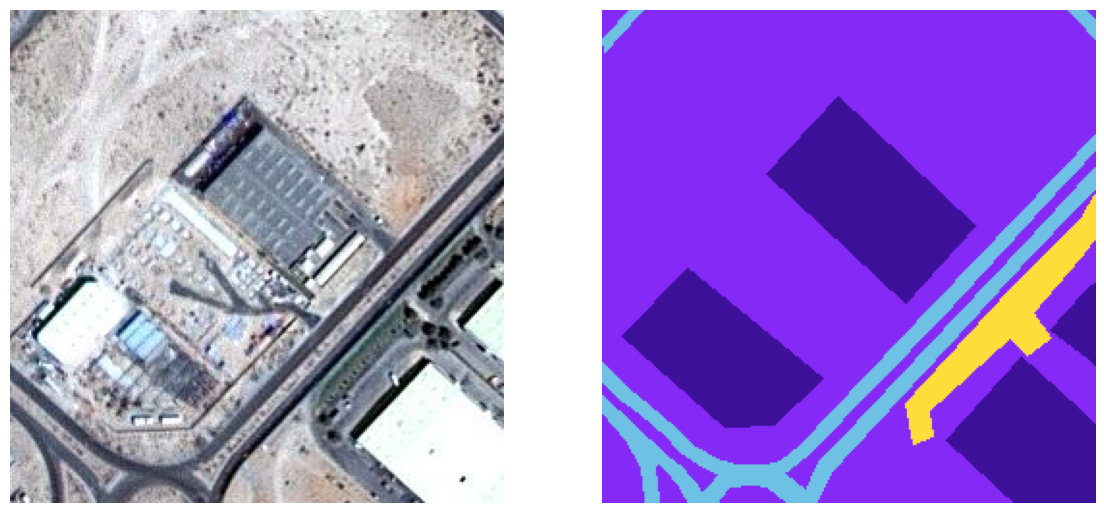

In [8]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.axis('off')
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])
plt.axis('off')

One-hot encoding using classes.json  

Each class e.g., building, land, road is represented by a specific color. During one-hot encoding of mask images, these RGB values can be used to identify pixels corresponding to each class and map them to class indices or binary masks.  

Extract the red ('3C'), green ('10'), and blue ('98') values and converts them to integers using int(hex, 16).  
The output for each class is an array of three integers, each representing the RGB values.

In [9]:
# One-hot encoding
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [10]:
label = individual_patched_mask

Models expect masks in the form of class indices (e.g., 0 for water, 1 for land).  
For example:  
[226, 169, 41] corresponds to class 0 (water),  
[155, 155, 155] corresponds to class 5 (unlabeled),  
[254, 221, 58] corresponds to class 4 (vegetation),  
[110, 193, 228] corresponds to class 2 (road)

In [11]:
def rgb_to_label(label):
    '''
    The function translates human-readable RGB masks into numerical format required for training and evaluation.
    Args:
        label: An RGB-encoded mask image, where each pixel has an RGB value corresponding to a specific class (e.g., buildings, water, etc.).
    '''
    label_segment = np.zeros(label.shape, dtype=np.uint8)
    label_segment[np.all(label == class_water, axis=-1)] = 0
    label_segment[np.all(label == class_land, axis=-1)] = 1
    label_segment[np.all(label == class_road, axis=-1)] = 2
    label_segment[np.all(label == class_building, axis=-1)] = 3
    label_segment[np.all(label == class_vegetation, axis=-1)] = 4
    label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
      
    label_segment = label_segment[:,:,0]
      
    return label_segment

In [12]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [13]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [14]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

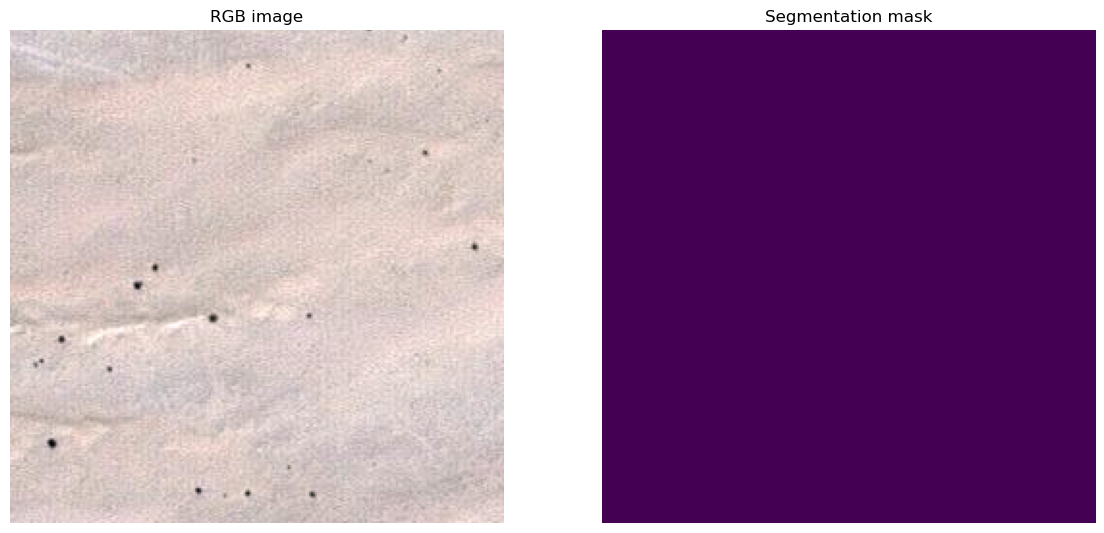

In [15]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.title("RGB image")
plt.axis('off')
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.title("Segmentation mask")
plt.axis('off')
plt.imshow(labels[random_image_id][:,:,0])

In [16]:
total_classes = len(np.unique(labels))
total_classes

6

In [17]:
labels_cat_dataset = to_categorical(labels, num_classes = total_classes)
training_dataset = image_dataset

X_train, X_test, y_train, y_test = train_test_split(training_dataset, labels_cat_dataset, test_size=0.15, random_state=100)

In [18]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)
256
256
3
6


Focal loss function > https://medium.com/visionwizard/understanding-focal-loss-a-quick-read-b914422913e7  
IoU > https://medium.com/analytics-vidhya/iou-intersection-over-union-705a39e7acef  
Jaccard Index > https://www.statisticshowto.com/jaccard-index/

The Jaccard coefficient is defined as:


$$J(A, B) = \frac{|A \cap B|}{|A \cup B|}$$


Here:

- $|A \cap B| $: The intersection, already computed.
- $ |A \cup B| $: The union, calculated as:

  $$|A \cup B| = |A| + |B| - |A \cap B|$$


Adding \( 1.0 \) to the numerator and denominator is a smoothing term to avoid division by zero when both `y_true` and `y_pred` are empty (i.e., when the intersection and union are zero).


In [19]:
# define Jaccard function with training data

def jaccard_coef(y_true, y_pred):
    '''Computes the Jaccard coefficient.
    Args:
        y_true: Ground truth binary mask (or set of values).
        y_pred: Predicted binary mask (or set of values).
    '''
    y_true_flatten = tf.keras.backend.flatten(y_true)
    y_pred_flatten = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (tf.keras.backend.sum(y_true_flatten) + tf.keras.backend.sum(y_pred_flatten) - intersection + 1.0)
    return final_coef_value

Follow U-Net architecture > https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/  

[u-net-arch-img-link](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

-  convulution parameter (first number) is changed from original architecture due to our use case (for every next layer filter needs to be doubled)
-  dropout parameter can be changed and experimented for use case

In [20]:
# Build model
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):
    '''
    Defines a U-Net architecture for semantic segmentation and consists of an encoder-decoder architecture, where the encoder extracts features from the image and the decoder reconstructs the image to output a segmentation map used for image segmentation.
    Args:
        n_classes: The number of output classes for segmentation (e.g., 5).
        image_height, image_width: The dimensions of the input image (default 256x256).
        image_channels: The number of channels in the input image (default 1, for grayscale).
    '''
    
    inputs = Input((image_height, image_width, image_channels))

    source_input = inputs

    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

    outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [21]:
# Define metrics
metrics = ["accuracy", jaccard_coef]

print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


In [22]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes, 
                          image_height=image_height, 
                          image_width=image_width, 
                          image_channels=image_channels)

In [23]:
model = get_deep_learning_model()

In [24]:
# model.get_config()

#### Define Loss Function  
dice loss > Focal Loss > Total Loss  
Total Loss = (Dice loss + (1*Focal Loss))  


Class weights are used to balance the loss function in cases where some classes are more prevalent than others in the dataset (i.e., imbalanced datasets).  
Dice loss measures the overlap between predicted segmentation and ground truth. `class_weights` will adjust the contribution of each class.     
Dice loss: Focuses on overlap quality, improving segmentation performance.  
Focal loss: Emphasizes learning on hard-to-classify examples, addressing class imbalance.

In [25]:
# Define loss function and weights
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
# Generate dice loss by passing the weights
dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

#### Model compliation

In [26]:
tf.keras.backend.clear_session()
# Adam optimizer for classification
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)
# Generate model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 16)      │             448 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 256, 256, 16)      │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 16)      │           2,320 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 128, 128, 16)      │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 128, 128, 32)      │           4,640 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 128, 128, 32)      │               0 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 32)      │           9,248 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 64, 64, 32)        │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 64, 64, 64)        │          18,496 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 64, 64, 64)        │               0 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 64, 64, 64)        │          36,928 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 32, 32, 64)        │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 32, 32, 128)       │          73,856 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 32, 32, 128)       │               0 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 32, 32, 128)       │         147,584 │ dropout_3[0][0]            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 1,941,190 (7.41 MB)

 Trainable params: 1,941,190 (7.41 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model_history = model.fit(X_train, y_train,
                          batch_size = 16, # 45 - 50 images will be processed each time
                          verbose = 1,
                          epochs = 100,
                          validation_data = (X_test, y_test),
                          shuffle = False)

Epoch 1/100


C:\Users\zhech\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


51/51 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.3728 - jaccard_coef: 0.1761 - loss: 1.0156 - val_accuracy: 0.5462 - val_jaccard_coef: 0.2847 - val_loss: 0.9929
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.5972 - jaccard_coef: 0.3247 - loss: 0.9909 - val_accuracy: 0.6518 - val_jaccard_coef: 0.3365 - val_loss: 0.9804
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.6893 - jaccard_coef: 0.4024 - loss: 0.9753 - val_accuracy: 0.7100 - val_jaccard_coef: 0.4264 - val_loss: 0.9630
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.7236 - jaccard_coef: 0.4737 - loss: 0.9609 - val_accuracy: 0.6746 - val_jaccard_coef: 0.4126 - val_loss: 0.9752
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.7398 - jaccard_coef: 0.4919 - loss: 0.9566 - val_accuracy: 0.6508 - val_jaccard_coef: 0.3938 - val_loss: 0.9726
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.7590 - jaccard_coef: 0.5209 - loss: 0.9497 - val_accuracy: 0.

51/51 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.3728 - jaccard_coef: 0.1761 - loss: 1.0156 - val_accuracy: 0.5462 - val_jaccard_coef: 0.2847 - val_loss: 0.9929  
Epoch 2/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.5972 - jaccard_coef: 0.3247 - loss: 0.9909 - val_accuracy: 0.6518 - val_jaccard_coef: 0.3365 - val_loss: 0.9804  
Epoch 3/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.6893 - jaccard_coef: 0.4024 - loss: 0.9753 - val_accuracy: 0.7100 - val_jaccard_coef: 0.4264 - val_loss: 0.9630  
Epoch 4/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.7236 - jaccard_coef: 0.4737 - loss: 0.9609 - val_accuracy: 0.6746 - val_jaccard_coef: 0.4126 - val_loss: 0.9752  
Epoch 5/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.7398 - jaccard_coef: 0.4919 - loss: 0.9566 - val_accuracy: 0.6508 - val_jaccard_coef: 0.3938 - val_loss: 0.9726  
Epoch 6/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.7590 - jaccard_coef: 0.5209 - loss: 0.9497 - val_accuracy: 0.6635 - val_jaccard_coef: 0.4278 - val_loss: 0.9760  
Epoch 7/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.7704 - jaccard_coef: 0.5440 - loss: 0.9453 - val_accuracy: 0.6848 - val_jaccard_coef: 0.4588 - val_loss: 0.9767  
Epoch 8/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.7829 - jaccard_coef: 0.5664 - loss: 0.9414 - val_accuracy: 0.7432 - val_jaccard_coef: 0.5160 - val_loss: 0.9560  
Epoch 9/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.7984 - jaccard_coef: 0.5877 - loss: 0.9360 - val_accuracy: 0.7756 - val_jaccard_coef: 0.5413 - val_loss: 0.9432  
Epoch 10/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8049 - jaccard_coef: 0.5973 - loss: 0.9340 - val_accuracy: 0.7680 - val_jaccard_coef: 0.5503 - val_loss: 0.9440  
Epoch 11/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8094 - jaccard_coef: 0.6097 - loss: 0.9322 - val_accuracy: 0.7903 - val_jaccard_coef: 0.5829 - val_loss: 0.9357  
Epoch 12/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8234 - jaccard_coef: 0.6350 - loss: 0.9271 - val_accuracy: 0.8010 - val_jaccard_coef: 0.6076 - val_loss: 0.9324  
Epoch 13/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8279 - jaccard_coef: 0.6448 - loss: 0.9248 - val_accuracy: 0.8109 - val_jaccard_coef: 0.6280 - val_loss: 0.9288  
Epoch 14/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8355 - jaccard_coef: 0.6597 - loss: 0.9218 - val_accuracy: 0.8095 - val_jaccard_coef: 0.6308 - val_loss: 0.9303  
Epoch 15/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8278 - jaccard_coef: 0.6480 - loss: 0.9240 - val_accuracy: 0.8222 - val_jaccard_coef: 0.6472 - val_loss: 0.9251  
Epoch 16/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8401 - jaccard_coef: 0.6691 - loss: 0.9191 - val_accuracy: 0.8194 - val_jaccard_coef: 0.6462 - val_loss: 0.9262  
Epoch 17/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8422 - jaccard_coef: 0.6718 - loss: 0.9186 - val_accuracy: 0.7951 - val_jaccard_coef: 0.6055 - val_loss: 0.9377  
Epoch 18/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8356 - jaccard_coef: 0.6595 - loss: 0.9210 - val_accuracy: 0.8311 - val_jaccard_coef: 0.6608 - val_loss: 0.9221  
Epoch 19/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8482 - jaccard_coef: 0.6834 - loss: 0.9160 - val_accuracy: 0.8168 - val_jaccard_coef: 0.6308 - val_loss: 0.9252  
Epoch 20/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8484 - jaccard_coef: 0.6828 - loss: 0.9158 - val_accuracy: 0.8342 - val_jaccard_coef: 0.6665 - val_loss: 0.9196  
Epoch 21/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8552 - jaccard_coef: 0.6938 - loss: 0.9130 - val_accuracy: 0.8455 - val_jaccard_coef: 0.6800 - val_loss: 0.9164  
Epoch 22/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8591 - jaccard_coef: 0.7008 - loss: 0.9115 - val_accuracy: 0.8497 - val_jaccard_coef: 0.6890 - val_loss: 0.9153  
Epoch 23/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8637 - jaccard_coef: 0.7096 - loss: 0.9099 - val_accuracy: 0.8493 - val_jaccard_coef: 0.6882 - val_loss: 0.9148  
Epoch 24/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8663 - jaccard_coef: 0.7129 - loss: 0.9087 - val_accuracy: 0.8481 - val_jaccard_coef: 0.6835 - val_loss: 0.9152  
Epoch 25/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8705 - jaccard_coef: 0.7193 - loss: 0.9073 - val_accuracy: 0.8539 - val_jaccard_coef: 0.6998 - val_loss: 0.9144  
Epoch 26/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8730 - jaccard_coef: 0.7239 - loss: 0.9066 - val_accuracy: 0.8512 - val_jaccard_coef: 0.6907 - val_loss: 0.9150  
Epoch 27/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8747 - jaccard_coef: 0.7275 - loss: 0.9060 - val_accuracy: 0.8530 - val_jaccard_coef: 0.6924 - val_loss: 0.9137  
Epoch 28/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8751 - jaccard_coef: 0.7275 - loss: 0.9053 - val_accuracy: 0.8519 - val_jaccard_coef: 0.6919 - val_loss: 0.9132  
Epoch 29/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8755 - jaccard_coef: 0.7296 - loss: 0.9051 - val_accuracy: 0.8579 - val_jaccard_coef: 0.7039 - val_loss: 0.9125  
Epoch 30/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.8792 - jaccard_coef: 0.7347 - loss: 0.9040 - val_accuracy: 0.8516 - val_jaccard_coef: 0.6964 - val_loss: 0.9149  
Epoch 31/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.8822 - jaccard_coef: 0.7400 - loss: 0.9027 - val_accuracy: 0.8564 - val_jaccard_coef: 0.7010 - val_loss: 0.9140  
Epoch 32/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.8848 - jaccard_coef: 0.7434 - loss: 0.9016 - val_accuracy: 0.8545 - val_jaccard_coef: 0.7017 - val_loss: 0.9150  
Epoch 33/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8823 - jaccard_coef: 0.7387 - loss: 0.9021 - val_accuracy: 0.8589 - val_jaccard_coef: 0.7149 - val_loss: 0.9140  
Epoch 34/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.8882 - jaccard_coef: 0.7511 - loss: 0.8997 - val_accuracy: 0.8533 - val_jaccard_coef: 0.6981 - val_loss: 0.9157  
Epoch 35/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8866 - jaccard_coef: 0.7471 - loss: 0.9004 - val_accuracy: 0.8542 - val_jaccard_coef: 0.7045 - val_loss: 0.9156  
Epoch 36/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 3122s 62s/step - accuracy: 0.8927 - jaccard_coef: 0.7573 - loss: 0.8980 - val_accuracy: 0.8536 - val_jaccard_coef: 0.7057 - val_loss: 0.9152  
Epoch 37/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8913 - jaccard_coef: 0.7563 - loss: 0.8983 - val_accuracy: 0.8458 - val_jaccard_coef: 0.6929 - val_loss: 0.9170  
Epoch 38/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.8906 - jaccard_coef: 0.7525 - loss: 0.8985 - val_accuracy: 0.8493 - val_jaccard_coef: 0.7076 - val_loss: 0.9185  
Epoch 39/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8902 - jaccard_coef: 0.7557 - loss: 0.8982 - val_accuracy: 0.8513 - val_jaccard_coef: 0.7043 - val_loss: 0.9159  
Epoch 40/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8915 - jaccard_coef: 0.7611 - loss: 0.8972 - val_accuracy: 0.8549 - val_jaccard_coef: 0.7155 - val_loss: 0.9143  
Epoch 41/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8915 - jaccard_coef: 0.7635 - loss: 0.8967 - val_accuracy: 0.8554 - val_jaccard_coef: 0.7167 - val_loss: 0.9139  
Epoch 42/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8921 - jaccard_coef: 0.7678 - loss: 0.8956 - val_accuracy: 0.8552 - val_jaccard_coef: 0.7209 - val_loss: 0.9128  
Epoch 43/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8903 - jaccard_coef: 0.7678 - loss: 0.8956 - val_accuracy: 0.8056 - val_jaccard_coef: 0.6555 - val_loss: 0.9221  
Epoch 44/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8941 - jaccard_coef: 0.7744 - loss: 0.8949 - val_accuracy: 0.8559 - val_jaccard_coef: 0.7256 - val_loss: 0.9140  
Epoch 45/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8958 - jaccard_coef: 0.7788 - loss: 0.8930 - val_accuracy: 0.8491 - val_jaccard_coef: 0.7160 - val_loss: 0.9156  
Epoch 46/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8924 - jaccard_coef: 0.7736 - loss: 0.8950 - val_accuracy: 0.8571 - val_jaccard_coef: 0.7255 - val_loss: 0.9111  
Epoch 47/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8957 - jaccard_coef: 0.7796 - loss: 0.8940 - val_accuracy: 0.8549 - val_jaccard_coef: 0.7244 - val_loss: 0.9137  
Epoch 48/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8956 - jaccard_coef: 0.7785 - loss: 0.8934 - val_accuracy: 0.8508 - val_jaccard_coef: 0.7220 - val_loss: 0.9164  
Epoch 49/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8962 - jaccard_coef: 0.7810 - loss: 0.8932 - val_accuracy: 0.8598 - val_jaccard_coef: 0.7334 - val_loss: 0.9130  
Epoch 50/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8963 - jaccard_coef: 0.7795 - loss: 0.8931 - val_accuracy: 0.8582 - val_jaccard_coef: 0.7336 - val_loss: 0.9126  
Epoch 51/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8872 - jaccard_coef: 0.7657 - loss: 0.8973 - val_accuracy: 0.8548 - val_jaccard_coef: 0.7259 - val_loss: 0.9139  
Epoch 52/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8911 - jaccard_coef: 0.7696 - loss: 0.8954 - val_accuracy: 0.8540 - val_jaccard_coef: 0.7280 - val_loss: 0.9114  
Epoch 53/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8874 - jaccard_coef: 0.7647 - loss: 0.8963 - val_accuracy: 0.8444 - val_jaccard_coef: 0.7099 - val_loss: 0.9166  
Epoch 54/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8809 - jaccard_coef: 0.7514 - loss: 0.8991 - val_accuracy: 0.8589 - val_jaccard_coef: 0.7284 - val_loss: 0.9119  
Epoch 55/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8886 - jaccard_coef: 0.7660 - loss: 0.8971 - val_accuracy: 0.8620 - val_jaccard_coef: 0.7351 - val_loss: 0.9107  
Epoch 56/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8917 - jaccard_coef: 0.7732 - loss: 0.8934 - val_accuracy: 0.8626 - val_jaccard_coef: 0.7331 - val_loss: 0.9095  
Epoch 57/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8835 - jaccard_coef: 0.7594 - loss: 0.8983 - val_accuracy: 0.8590 - val_jaccard_coef: 0.7289 - val_loss: 0.9109  
Epoch 58/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8961 - jaccard_coef: 0.7826 - loss: 0.8914 - val_accuracy: 0.8661 - val_jaccard_coef: 0.7431 - val_loss: 0.9099  
Epoch 59/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9010 - jaccard_coef: 0.7890 - loss: 0.8885 - val_accuracy: 0.8614 - val_jaccard_coef: 0.7311 - val_loss: 0.9088  
Epoch 60/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8892 - jaccard_coef: 0.7677 - loss: 0.8945 - val_accuracy: 0.8437 - val_jaccard_coef: 0.7053 - val_loss: 0.9166  
Epoch 61/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8929 - jaccard_coef: 0.7737 - loss: 0.8931 - val_accuracy: 0.8447 - val_jaccard_coef: 0.6997 - val_loss: 0.9181  
Epoch 62/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8903 - jaccard_coef: 0.7668 - loss: 0.8940 - val_accuracy: 0.8581 - val_jaccard_coef: 0.7254 - val_loss: 0.9123  
Epoch 63/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8988 - jaccard_coef: 0.7860 - loss: 0.8895 - val_accuracy: 0.8609 - val_jaccard_coef: 0.7336 - val_loss: 0.9113  
Epoch 64/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8962 - jaccard_coef: 0.7809 - loss: 0.8909 - val_accuracy: 0.8562 - val_jaccard_coef: 0.7262 - val_loss: 0.9131  
Epoch 65/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8990 - jaccard_coef: 0.7863 - loss: 0.8869 - val_accuracy: 0.8538 - val_jaccard_coef: 0.7247 - val_loss: 0.9142  
Epoch 66/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9040 - jaccard_coef: 0.7956 - loss: 0.8851 - val_accuracy: 0.8541 - val_jaccard_coef: 0.7269 - val_loss: 0.9127  
Epoch 67/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9015 - jaccard_coef: 0.7919 - loss: 0.8871 - val_accuracy: 0.8619 - val_jaccard_coef: 0.7374 - val_loss: 0.9104  
Epoch 68/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8891 - jaccard_coef: 0.7695 - loss: 0.8934 - val_accuracy: 0.8517 - val_jaccard_coef: 0.7189 - val_loss: 0.9150  
Epoch 69/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8917 - jaccard_coef: 0.7716 - loss: 0.8920 - val_accuracy: 0.8071 - val_jaccard_coef: 0.6550 - val_loss: 0.9280  
Epoch 70/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9075 - jaccard_coef: 0.8023 - loss: 0.8822 - val_accuracy: 0.8342 - val_jaccard_coef: 0.6976 - val_loss: 0.9201  
Epoch 71/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9117 - jaccard_coef: 0.8101 - loss: 0.8799 - val_accuracy: 0.8629 - val_jaccard_coef: 0.7400 - val_loss: 0.9091  
Epoch 72/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9073 - jaccard_coef: 0.8027 - loss: 0.8839 - val_accuracy: 0.8619 - val_jaccard_coef: 0.7394 - val_loss: 0.9103  
Epoch 73/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9100 - jaccard_coef: 0.8066 - loss: 0.8807 - val_accuracy: 0.8640 - val_jaccard_coef: 0.7423 - val_loss: 0.9086  
Epoch 74/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9152 - jaccard_coef: 0.8171 - loss: 0.8777 - val_accuracy: 0.8617 - val_jaccard_coef: 0.7379 - val_loss: 0.9108  
Epoch 75/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9146 - jaccard_coef: 0.8140 - loss: 0.8792 - val_accuracy: 0.8673 - val_jaccard_coef: 0.7508 - val_loss: 0.9064  
Epoch 76/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9113 - jaccard_coef: 0.8110 - loss: 0.8818 - val_accuracy: 0.8433 - val_jaccard_coef: 0.7128 - val_loss: 0.9141  
Epoch 77/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9104 - jaccard_coef: 0.8089 - loss: 0.8808 - val_accuracy: 0.8677 - val_jaccard_coef: 0.7495 - val_loss: 0.9089  
Epoch 78/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9179 - jaccard_coef: 0.8222 - loss: 0.8783 - val_accuracy: 0.8547 - val_jaccard_coef: 0.7280 - val_loss: 0.9136  
Epoch 79/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9180 - jaccard_coef: 0.8223 - loss: 0.8771 - val_accuracy: 0.8373 - val_jaccard_coef: 0.7007 - val_loss: 0.9176  
Epoch 80/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9119 - jaccard_coef: 0.8100 - loss: 0.8795 - val_accuracy: 0.8559 - val_jaccard_coef: 0.7276 - val_loss: 0.9086  
Epoch 81/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9142 - jaccard_coef: 0.8157 - loss: 0.8779 - val_accuracy: 0.8609 - val_jaccard_coef: 0.7408 - val_loss: 0.9096  
Epoch 82/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9052 - jaccard_coef: 0.7988 - loss: 0.8816 - val_accuracy: 0.8675 - val_jaccard_coef: 0.7480 - val_loss: 0.9062  
Epoch 83/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9196 - jaccard_coef: 0.8254 - loss: 0.8751 - val_accuracy: 0.8581 - val_jaccard_coef: 0.7363 - val_loss: 0.9124  
Epoch 84/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9182 - jaccard_coef: 0.8243 - loss: 0.8748 - val_accuracy: 0.8675 - val_jaccard_coef: 0.7489 - val_loss: 0.9096  
Epoch 85/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9184 - jaccard_coef: 0.8237 - loss: 0.8750 - val_accuracy: 0.8685 - val_jaccard_coef: 0.7524 - val_loss: 0.9102  
Epoch 86/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9191 - jaccard_coef: 0.8248 - loss: 0.8742 - val_accuracy: 0.8570 - val_jaccard_coef: 0.7348 - val_loss: 0.9168  
Epoch 87/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9018 - jaccard_coef: 0.7933 - loss: 0.8849 - val_accuracy: 0.8591 - val_jaccard_coef: 0.7271 - val_loss: 0.9114  
Epoch 88/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9011 - jaccard_coef: 0.7862 - loss: 0.8837 - val_accuracy: 0.8627 - val_jaccard_coef: 0.7365 - val_loss: 0.9096  
Epoch 89/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9163 - jaccard_coef: 0.8173 - loss: 0.8758 - val_accuracy: 0.8629 - val_jaccard_coef: 0.7436 - val_loss: 0.9111  
Epoch 90/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9221 - jaccard_coef: 0.8315 - loss: 0.8720 - val_accuracy: 0.8679 - val_jaccard_coef: 0.7485 - val_loss: 0.9090  
Epoch 91/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9212 - jaccard_coef: 0.8291 - loss: 0.8729 - val_accuracy: 0.8677 - val_jaccard_coef: 0.7509 - val_loss: 0.9080  
Epoch 92/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9237 - jaccard_coef: 0.8332 - loss: 0.8712 - val_accuracy: 0.8621 - val_jaccard_coef: 0.7411 - val_loss: 0.9098  
Epoch 93/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9173 - jaccard_coef: 0.8210 - loss: 0.8745 - val_accuracy: 0.8658 - val_jaccard_coef: 0.7450 - val_loss: 0.9079  
Epoch 94/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9266 - jaccard_coef: 0.8387 - loss: 0.8698 - val_accuracy: 0.8688 - val_jaccard_coef: 0.7528 - val_loss: 0.9071  
Epoch 95/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9291 - jaccard_coef: 0.8449 - loss: 0.8688 - val_accuracy: 0.8668 - val_jaccard_coef: 0.7488 - val_loss: 0.9072  
Epoch 96/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9252 - jaccard_coef: 0.8364 - loss: 0.8701 - val_accuracy: 0.8656 - val_jaccard_coef: 0.7466 - val_loss: 0.9085  
Epoch 97/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9145 - jaccard_coef: 0.8164 - loss: 0.8766 - val_accuracy: 0.8660 - val_jaccard_coef: 0.7458 - val_loss: 0.9106  
Epoch 98/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9099 - jaccard_coef: 0.8070 - loss: 0.8801 - val_accuracy: 0.8529 - val_jaccard_coef: 0.7259 - val_loss: 0.9102  
Epoch 99/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9228 - jaccard_coef: 0.8306 - loss: 0.8729 - val_accuracy: 0.8672 - val_jaccard_coef: 0.7443 - val_loss: 0.9066  
Epoch 100/100  
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9225 - jaccard_coef: 0.8300 - loss: 0.8723 - val_accuracy: 0.8673 - val_jaccard_coef: 0.7505 - val_loss: 0.9084  

In [28]:
history_a = model_history
history_a.history

{'accuracy': [0.4951876103878021,
  0.624553382396698,
  0.697767972946167,
  0.7215756177902222,
  0.7407582998275757,
  0.7580750584602356,
  0.7755250334739685,
  0.7877224683761597,
  0.7998279333114624,
  0.8045380711555481,
  0.8134428262710571,
  0.8243237733840942,
  0.8304377198219299,
  0.8356605172157288,
  0.8342575430870056,
  0.8398128747940063,
  0.8372565507888794,
  0.8425969481468201,
  0.8422613143920898,
  0.8497694730758667,
  0.8568307757377625,
  0.8593413829803467,
  0.8637604117393494,
  0.8664872050285339,
  0.8705180287361145,
  0.8722113966941833,
  0.873781144618988,
  0.8751205205917358,
  0.8743667602539062,
  0.8797922134399414,
  0.8813793659210205,
  0.8856590390205383,
  0.8837183117866516,
  0.8878610134124756,
  0.8872379064559937,
  0.8914557695388794,
  0.8888795971870422,
  0.8904454112052917,
  0.8893051147460938,
  0.8918536305427551,
  0.8904756903648376,
  0.891303300857544,
  0.8906967639923096,
  0.8951637744903564,
  0.8963207006454468,
  

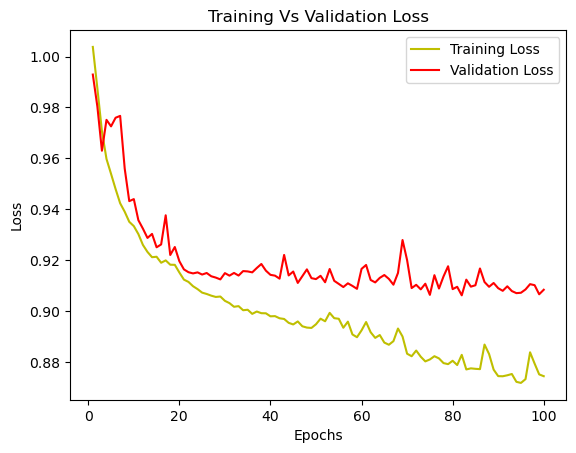

In [29]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plot model history
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

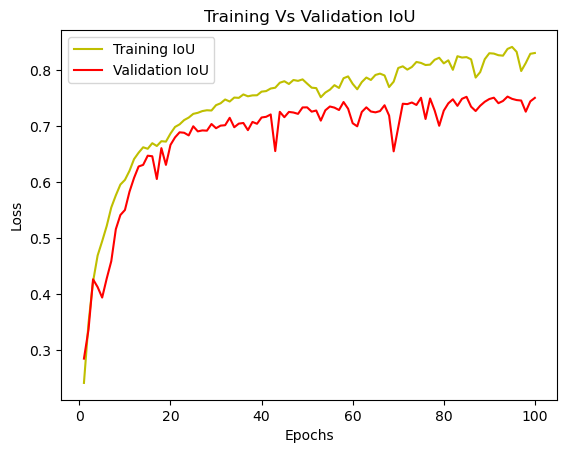

In [30]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

# Plot for Jaccard coef
epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Based on the graphs experimentation is needed to fine tune and have even better accutacy.

#### Generate predictions  
Compare test mask and predicted mask images

In [32]:
y_test_argmax = np.argmax(y_test, axis=3)

In [57]:
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number] # our mask
text_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(text_image_input)
predicted_image = np.argmax(prediction, axis = 3)
predicted_image = predicted_image[0, :, :]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


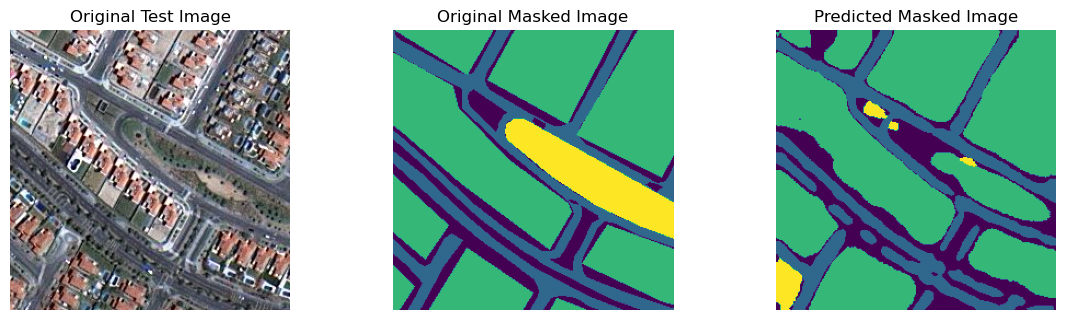

In [58]:
# Plot  prediction - actial image, actual mask and predicted mask
plt.figure(figsize = (14, 8))

plt.subplot(231)
plt.title("Original Test Image")
plt.axis('off')
plt.imshow(test_image)

plt.subplot(232)
plt.title("Original Masked Image")
plt.axis('off')
plt.imshow(ground_truth_image)

plt.subplot(233)
plt.title("Predicted Masked Image")
plt.axis('off')
plt.imshow(predicted_image)